# Task 8 — Traffic Sign Recognition

**Objective:** Build a CNN to classify traffic signs (GTSRB). This notebook includes:

### Description:
1. Dataset (Recommended): GTSRB (Kaggle)
2. Classify traffic signs based on their image using deep learning 
3. Preprocess images (resizing, normalization)
4. Train a CNN model to recognize different traffic sign classes 
5. Evaluate performance using accuracy and confusion matrix


Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50, MobileNetV2, MobileNetV3Small


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder


# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")


2025-10-15 19:22:07.993641: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.16.2
GPU Available: []


Configuration

In [2]:

# === Run training & evaluation using only existing functions ===
import glob, os, pprint
print("Working dir:", os.getcwd())

np.random.seed(42)
tf.random.set_seed(42)

TRAIN_PATH = '/Users/ahmedyahia/Downloads/welcometotheelevvointernshipprogram/datasets/gtsrb/Train.csv'  # path to Train.csv
TEST_PATH = '/Users/ahmedyahia/Downloads/welcometotheelevvointernshipprogram/datasets/gtsrb/Test.csv'    # path to Test.csv
image_base_path = '/Users/ahmedyahia/Downloads/welcometotheelevvointernshipprogram/datasets/gtsrb/'    # path to Test.csv

# Ensure image size variables exist
IMG_HEIGHT = globals().get('IMG_HEIGHT', 32)
IMG_WIDTH = globals().get('IMG_WIDTH', 32)
IMG_CHANNELS = globals().get('IMG_CHANNELS', 3)
BATCH_SIZE = globals().get('BATCH_SIZE', 32)
EPOCHS = globals().get('EPOCHS', 20)

print(f"IMG: {IMG_HEIGHT}x{IMG_WIDTH} channels={IMG_CHANNELS}, batch={BATCH_SIZE}, epochs={EPOCHS}")

# Try to locate a Train.csv in common locations (/mnt/data)
possible_csvs = glob.glob('/mnt/data/**/*Train*.csv', recursive=True) + glob.glob('/mnt/data/**/*train*.csv', recursive=True)
possible_csvs = [p for p in possible_csvs if 'Test' not in p and 'test' not in p]
train_csv = None
if possible_csvs:
    train_csv = possible_csvs[0]
    print("Found candidate train CSV:", train_csv)

# Fall back to TRAIN_PATH if present
if train_csv is None and 'TRAIN_PATH' in globals() and os.path.exists(TRAIN_PATH):
    train_csv = TRAIN_PATH
    print("Using TRAIN_PATH from notebook:", train_csv)

if train_csv is None:
    raise FileNotFoundError("Train CSV not found. Please place Train.csv under /mnt/data or set TRAIN_PATH in the notebook.")


Working dir: /Users/ahmedyahia/Downloads/welcometotheelevvointernshipprogram/ml_tasks
IMG: 32x32 channels=3, batch=32, epochs=20
Using TRAIN_PATH from notebook: /Users/ahmedyahia/Downloads/welcometotheelevvointernshipprogram/datasets/gtsrb/Train.csv


In [3]:
def load_data_from_csv(csv_path, img_base_path='', img_size=(IMG_HEIGHT, IMG_WIDTH)):
    """
    Load images from CSV file with columns: 'Path' or 'image_path', 'ClassId' or 'label'
    
    Args:
        csv_path: Path to CSV file
        img_base_path: Base path to prepend to image paths
        img_size: Target size for images
    
    Returns:
        X: numpy array of images
        y: numpy array of labels
    """
    df = pd.read_csv(csv_path)
    print(f"CSV shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    
    # Identify path and label columns
    path_col = 'Path' if 'Path' in df.columns else 'image_path'
    label_col = 'ClassId' if 'ClassId' in df.columns else 'label'
    
    images = []
    labels = []
    
    for idx, row in df.iterrows():
        img_path = os.path.join(img_base_path, row[path_col])
        try:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, img_size)
            images.append(img)
            labels.append(row[label_col])
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
        
        if (idx + 1) % 10000 == 0:
            print(f"Processed {idx + 1}/{len(df)} images")
    
    X = np.array(images, dtype='float32')
    y = np.array(labels)
    
    return X, y

Data Preprocessing

In [4]:
def ensure_one_hot(arr, num_classes=None):
    if arr is None:
        return arr
    arr = np.asarray(arr)
    if arr.ndim == 1 or (arr.ndim == 2 and arr.shape[1] == 1):
        if num_classes is None:
            num_classes = int(arr.max()) + 1
        return to_categorical(arr.reshape(-1), num_classes)
    return arr

def preprocess_X(X):
    # scale to [0,1]
    Xp = X / 255.0
    return Xp

def prepare_data(X, y, test_size=0.2, val_size=0.1, random_state=42):
    Xp = preprocess_X(X)
    X_train, X_val, y_train, y_val = train_test_split(Xp, y, test_size=test_size+val_size, random_state=random_state, stratify=y)

    return X_train, X_val, y_train, y_val


Load Dataset

In [5]:
print("=" * 70)
print("LOADING DATASET")
print("=" * 70)

print("\nLoading from CSV files...")
x, y = load_data_from_csv(TRAIN_PATH, img_base_path=image_base_path)
X_train, X_val, y_train, y_val = prepare_data(X=x, y=y)
print("Data split into Training and Validation successfully!")
X_test, y_test = load_data_from_csv(TEST_PATH, img_base_path=image_base_path)
X_test = preprocess_X(X_test)
class_names = [f"Class_{i}" for i in range(len(np.unique(y_train)))]

num_classes = len(np.unique(y_train))
print(f"\nNumber of classes: {num_classes}")

y_train = ensure_one_hot(y_train, num_classes=num_classes)
y_val  = ensure_one_hot(y_val,  num_classes=num_classes)
y_test  = ensure_one_hot(y_test,  num_classes=num_classes)



LOADING DATASET

Loading from CSV files...
CSV shape: (39209, 8)
Columns: ['Width', 'Height', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2', 'ClassId', 'Path']
Processed 10000/39209 images
Processed 20000/39209 images
Processed 30000/39209 images
Data split into Training and Validation successfully!
CSV shape: (12630, 8)
Columns: ['Width', 'Height', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2', 'ClassId', 'Path']
Processed 10000/12630 images

Number of classes: 43


Models

In [6]:
# Custom CNN model definition

def build_custom_cnn(input_shape=(48,48,3), num_classes=43):
    model = keras.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.4),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


def build_pretrained(input_shape=(96,96,3), num_classes=43, freeze_base=True):
    weights = "/Users/ahmedyahia/Downloads/welcometotheelevvointernshipprogram/weights/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5"
    try:
        base = MobileNetV2(
                            input_shape=input_shape,
                            alpha=float(1.0),
                            include_top=False,
                            weights=weights,
                            input_tensor=None,
                            pooling='max',
                            classifier_activation="softmax",
                            name=None,)
        print("Loaded MobileNetV2 with ImageNet weights.")
    except Exception as e:
        print("Warning: could not load MobileNetV2 pretrained weights (reason: {}).".format(e))
        print("Falling back to MobileNetV2 with random initialization (weights=None).")
        base = MobileNetV2(include_top=False, weights=None, input_shape=input_shape, pooling='avg', alpha=1.0)

    if freeze_base:
        base.trainable = False

    x = base.output
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs=base.input, outputs=out)
    model.compile(optimizer=keras.optimizers.Adam(1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

Training

In [7]:
# Training function with augmentation

def train_with_generator(model, X_train, y_train, X_val, y_val, batch_size=64, epochs=30, augment=True):
    if augment:
        datagen = ImageDataGenerator(
            rotation_range=10,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.05,
            zoom_range=0.1,
            horizontal_flip=False,
            fill_mode='nearest')
        datagen.fit(X_train)
        train_gen = datagen.flow(X_train, y_train, batch_size=batch_size)
        steps = len(X_train) // batch_size
        history = model.fit(train_gen, epochs=epochs, steps_per_epoch=steps, validation_data=(X_val, y_val))
    else:
        history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))
    return history

# Plot history
def plot_history(history):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.legend()
    plt.show()


Evaluation

In [8]:
def evaluate_and_report(model, X_test, y_test, class_labels=None):
    preds = model.predict(X_test)
    y_pred = np.argmax(preds, axis=1)
    y_true = np.argmax(y_test, axis=1)
    print(classification_report(y_true, y_pred, digits=4))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,8))
    plt.imshow(cm, interpolation='nearest')
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(cm))
    plt.xticks(tick_marks, tick_marks, rotation=90)
    plt.yticks(tick_marks, tick_marks)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    return cm

def show_sample_predictions(model, X, y, class_names=None, n=12):
    preds = model.predict(X[:n])
    y_pred = np.argmax(preds, axis=1)
    y_true = np.argmax(y[:n], axis=1)
    plt.figure(figsize=(12,6))
    for i in range(n):
        plt.subplot(3,4,i+1)
        plt.imshow((X[i]*255).astype('uint8'))
        plt.title(f'True:{y_true[i]}\nPred:{y_pred[i]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()


Custom Model

In [9]:
print("Building Custom model")
model1 = build_custom_cnn(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), num_classes=num_classes)
model1.summary()
# Train using the provided training function
print("Starting training with augmentation using train_with_generator...")
history = train_with_generator(model1, X_train, y_train, X_val=X_val, y_val=y_val,batch_size=BATCH_SIZE, epochs=EPOCHS, augment=True)

Building Custom model


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 676,939 (2.58 MB)

 Trainable params: 675,979 (2.58 MB)

 Non-trainable params: 960 (3.75 KB)

Starting training with augmentation using train_with_generator...
Epoch 1/20
857/857 ━━━━━━━━━━━━━━━━━━━━ 118s 134ms/step - accuracy: 0.1922 - loss: 3.4532 - val_accuracy: 0.7418 - val_loss: 0.8035
Epoch 2/20
857/857 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.4375 - loss: 1.5973 - val_accuracy: 0.7401 - val_loss: 0.8074
Epoch 3/20
857/857 ━━━━━━━━━━━━━━━━━━━━ 112s 131ms/step - accuracy: 0.7010 - loss: 0.9521 - val_accuracy: 0.9229 - val_loss: 0.2675
Epoch 4/20
857/857 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8438 - loss: 0.3904 - val_accuracy: 0.9253 - val_loss: 0.2597
Epoch 5/20
857/857 ━━━━━━━━━━━━━━━━━━━━ 112s 131ms/step - accuracy: 0.8662 - loss: 0.4182 - val_accuracy: 0.9701 - val_loss: 0.1042
Epoch 6/20
857/857 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9062 - loss: 0.2369 - val_accuracy: 0.9680 - val_loss: 0.1147
Epoch 7/20
857/857 ━━━━━━━━━━━━━━━━━━━━ 116s 136ms/step - accuracy: 0.9184 - loss: 0.2543 - val_accuracy: 0.9571 - val_loss: 0.1408
Epoch 8/20
857/857 ━━━

Pre-trained

In [10]:
# Build model using provided builder
print("Building Pre-trained model (freeze base)...")
model2 = build_pretrained(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), num_classes=num_classes, freeze_base=True)
model2.summary()
# Train using the provided training function
print("Starting training with augmentation using train_with_generator...")
history2 = train_with_generator(model2, X_train, y_train, X_val=X_val, y_val=y_val,batch_size=BATCH_SIZE, epochs=EPOCHS, augment=True)


Building Pre-trained model (freeze base)...
Loaded MobileNetV2 with ImageNet weights.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 16, 16,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 16, 16,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 16, 16,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 16, 16,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 16, 16,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 16, 16,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 16, 16,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 16, 16,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 17, 17,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 8, 8, 96)  │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 8, 8, 96)  │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 8, 8, 96)  │          0 │ block_1_depthwis… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 8, 8, 24)  │      2,304 │ block_1_depthwis

 Total params: 2,935,915 (11.20 MB)

 Trainable params: 677,931 (2.59 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Starting training with augmentation using train_with_generator...
Epoch 1/20
857/857 ━━━━━━━━━━━━━━━━━━━━ 48s 51ms/step - accuracy: 0.0985 - loss: 3.5514 - val_accuracy: 0.1957 - val_loss: 3.0489
Epoch 2/20
857/857 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.2500 - loss: 3.0346 - val_accuracy: 0.1961 - val_loss: 3.0484
Epoch 3/20
857/857 ━━━━━━━━━━━━━━━━━━━━ 44s 52ms/step - accuracy: 0.1985 - loss: 2.9953 - val_accuracy: 0.2401 - val_loss: 2.7975
Epoch 4/20
857/857 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.3750 - loss: 2.4517 - val_accuracy: 0.2404 - val_loss: 2.7973
Epoch 5/20
857/857 ━━━━━━━━━━━━━━━━━━━━ 40s 47ms/step - accuracy: 0.2281 - loss: 2.7916 - val_accuracy: 0.2506 - val_loss: 2.6709
Epoch 6/20
857/857 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.2812 - loss: 2.6747 - val_accuracy: 0.2504 - val_loss: 2.6708
Epoch 7/20
857/857 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - accuracy: 0.2466 - loss: 2.6834 - val_accuracy: 0.2658 - val_loss: 2.5896
Epoch 8/20
857/857 ━━━━━━━━

Visualization

Plotting Custom Network history...


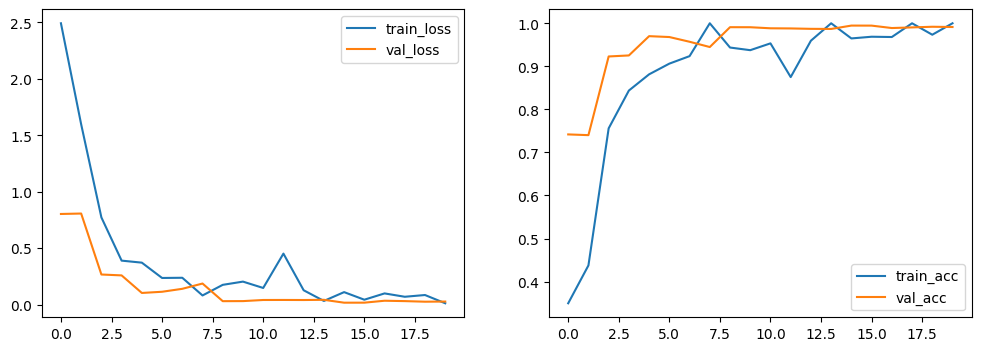

Evaluating Custom Network on test set...
395/395 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        60
           1     0.9742    0.9972    0.9856       720
           2     0.9765    0.9960    0.9861       750
           3     0.9931    0.9533    0.9728       450
           4     1.0000    0.9667    0.9831       660
           5     0.9035    0.9810    0.9406       630
           6     0.9868    1.0000    0.9934       150
           7     0.9976    0.9178    0.9560       450
           8     0.9553    0.9489    0.9521       450
           9     1.0000    1.0000    1.0000       480
          10     1.0000    0.9864    0.9931       660
          11     0.9834    0.9881    0.9857       420
          12     0.9413    1.0000    0.9698       690
          13     0.9986    0.9889    0.9937       720
          14     0.9963    1.0000    0.9982       270
          15     1.0000    0.9905    0.9952       21

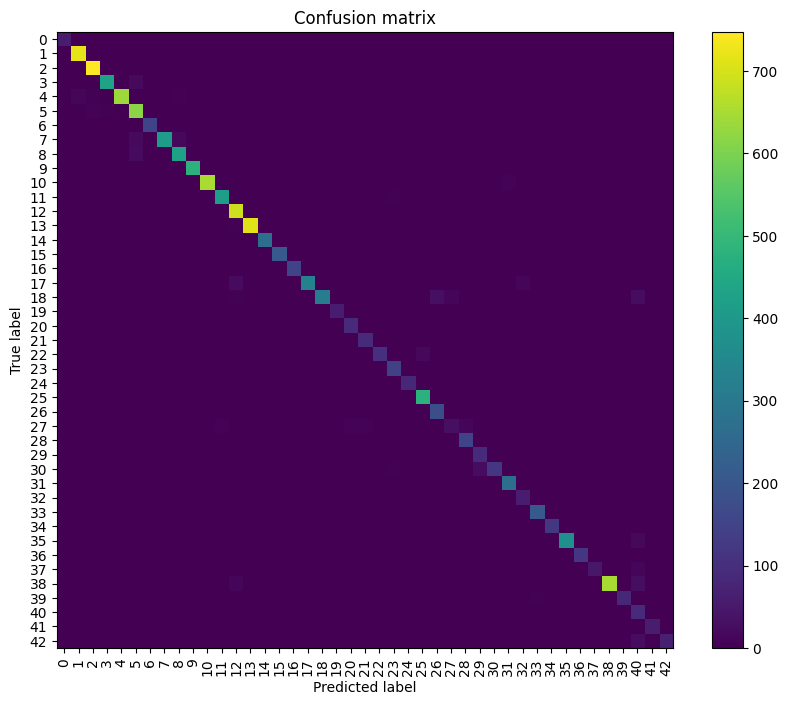

Custom Network Sample predictions on test set:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


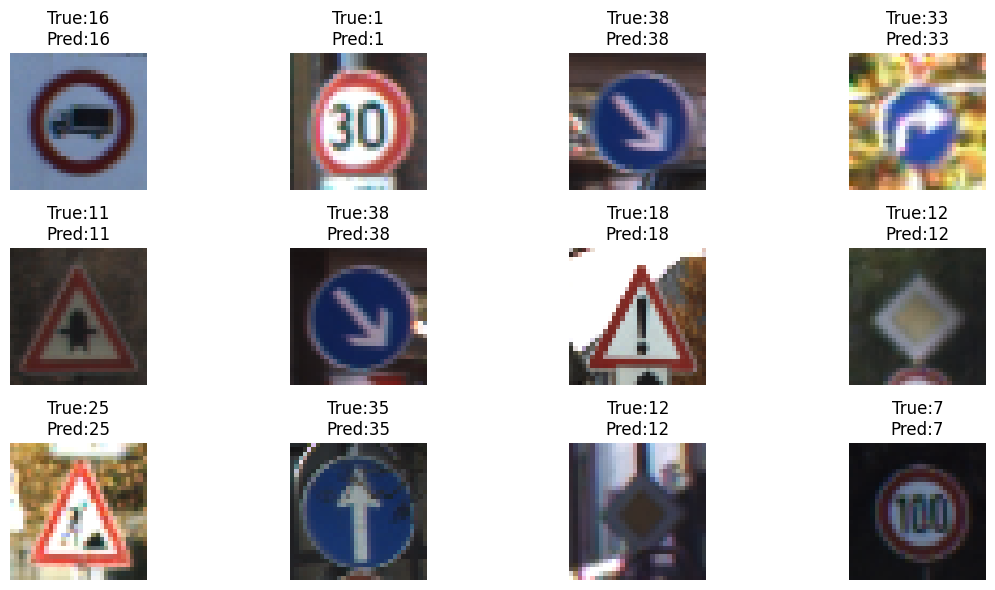

In [11]:
# Plot training curves using provided function
print("Plotting Custom Network history...")
plot_history(history)

# Evaluate using provided evaluate_and_report
print("Evaluating Custom Network on test set...")
evaluate_and_report(model1, X_test, y_test, class_labels=None)

# Show some sample predictions
print("Custom Network Sample predictions on test set:")
show_sample_predictions(model1, X_test, y_test, class_names=None, n=12)


Plotting ResNet history...


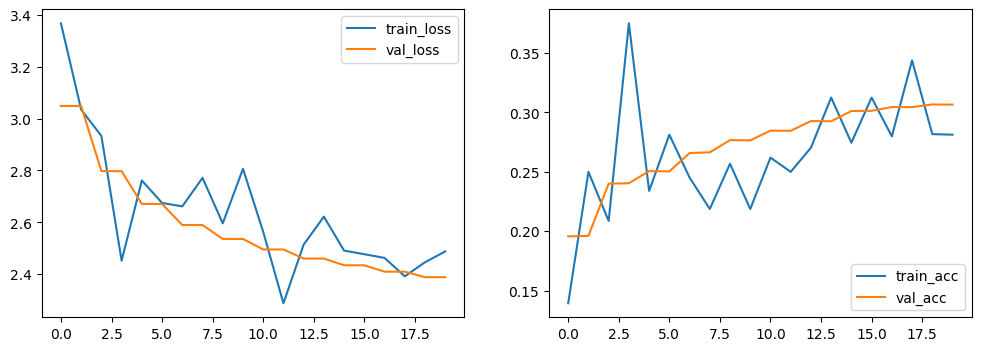

Evaluating ResNet on test set...
395/395 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        60
           1     0.2457    0.3792    0.2982       720
           2     0.1748    0.3347    0.2296       750
           3     0.0863    0.0600    0.0708       450
           4     0.1801    0.1152    0.1405       660
           5     0.2457    0.3413    0.2857       630
           6     0.4429    0.2067    0.2818       150
           7     0.1796    0.0667    0.0972       450
           8     0.2674    0.1622    0.2019       450
           9     0.1582    0.1042    0.1256       480
          10     0.3281    0.4455    0.3779       660
          11     0.2003    0.3000    0.2402       420
          12     0.3173    0.7449    0.4450       690
          13     0.5035    0.6903    0.5823       720
          14     0.2458    0.1074    0.1495       270
          15     0.4149    0.1857    0.2566       210
     

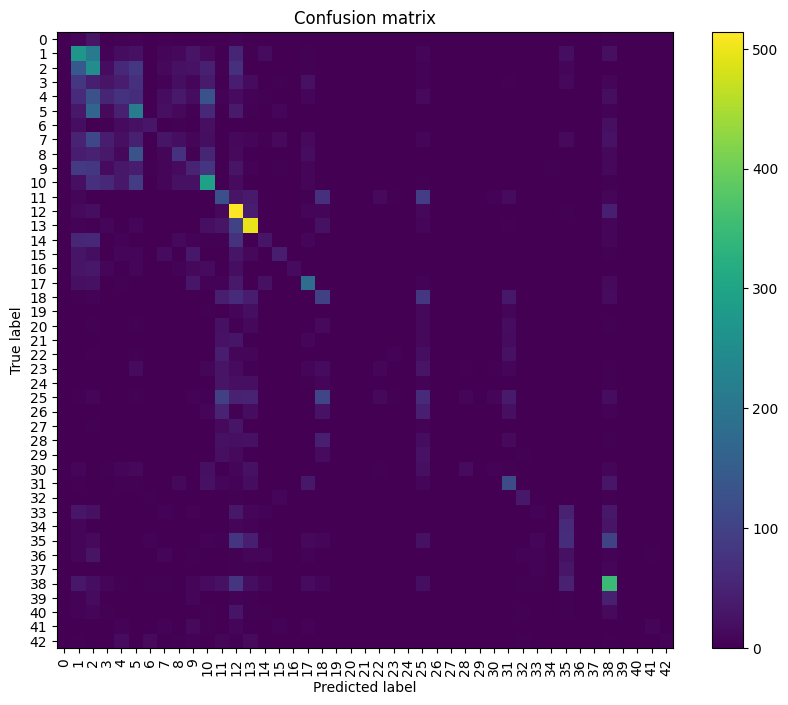

ResNet Sample predictions on test set:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


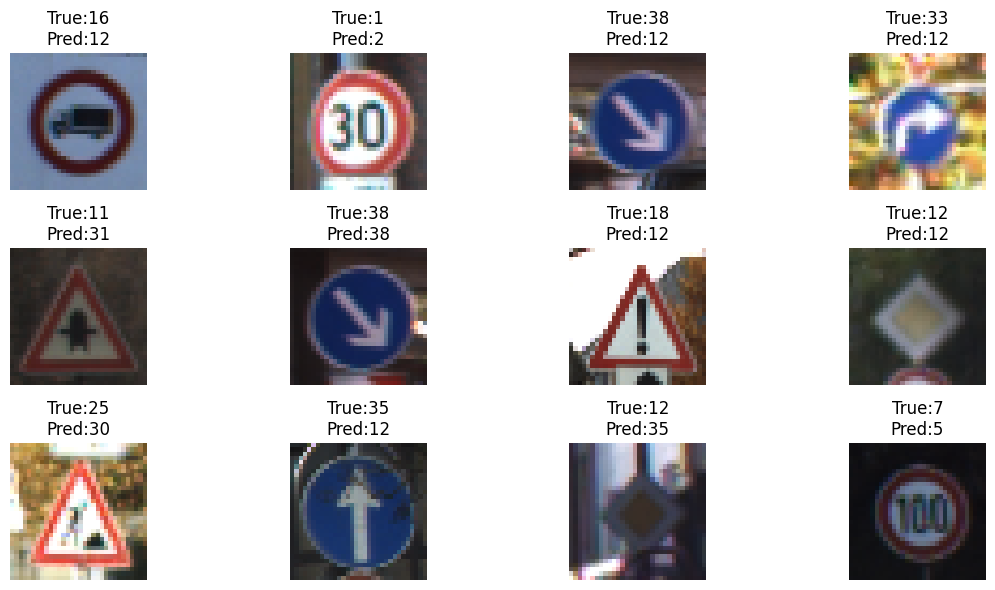

In [12]:
# Plot training curves using provided function
print("Plotting ResNet history...")
plot_history(history2)

# Evaluate using provided evaluate_and_report
print("Evaluating ResNet on test set...")
evaluate_and_report(model2, X_test, y_test, class_labels=None)

# Show some sample predictions
print("ResNet Sample predictions on test set:")
show_sample_predictions(model2, X_test, y_test, class_names=None, n=12)
